# Вариант 1-05

---

Линейная регрессия:

$$ h(x) = \tilde{y}(x) = \beta_0 + \beta_1 x + \dots + \beta_m x^m $$

Lasso:

$$ \tilde{\beta} = \arg \min \left( \sum_i (y_i - \tilde{y}_i)^2 +\lambda \sum_{i}|\beta_i| \right) $$

---

## Считываем и обрабатываем выборку

300


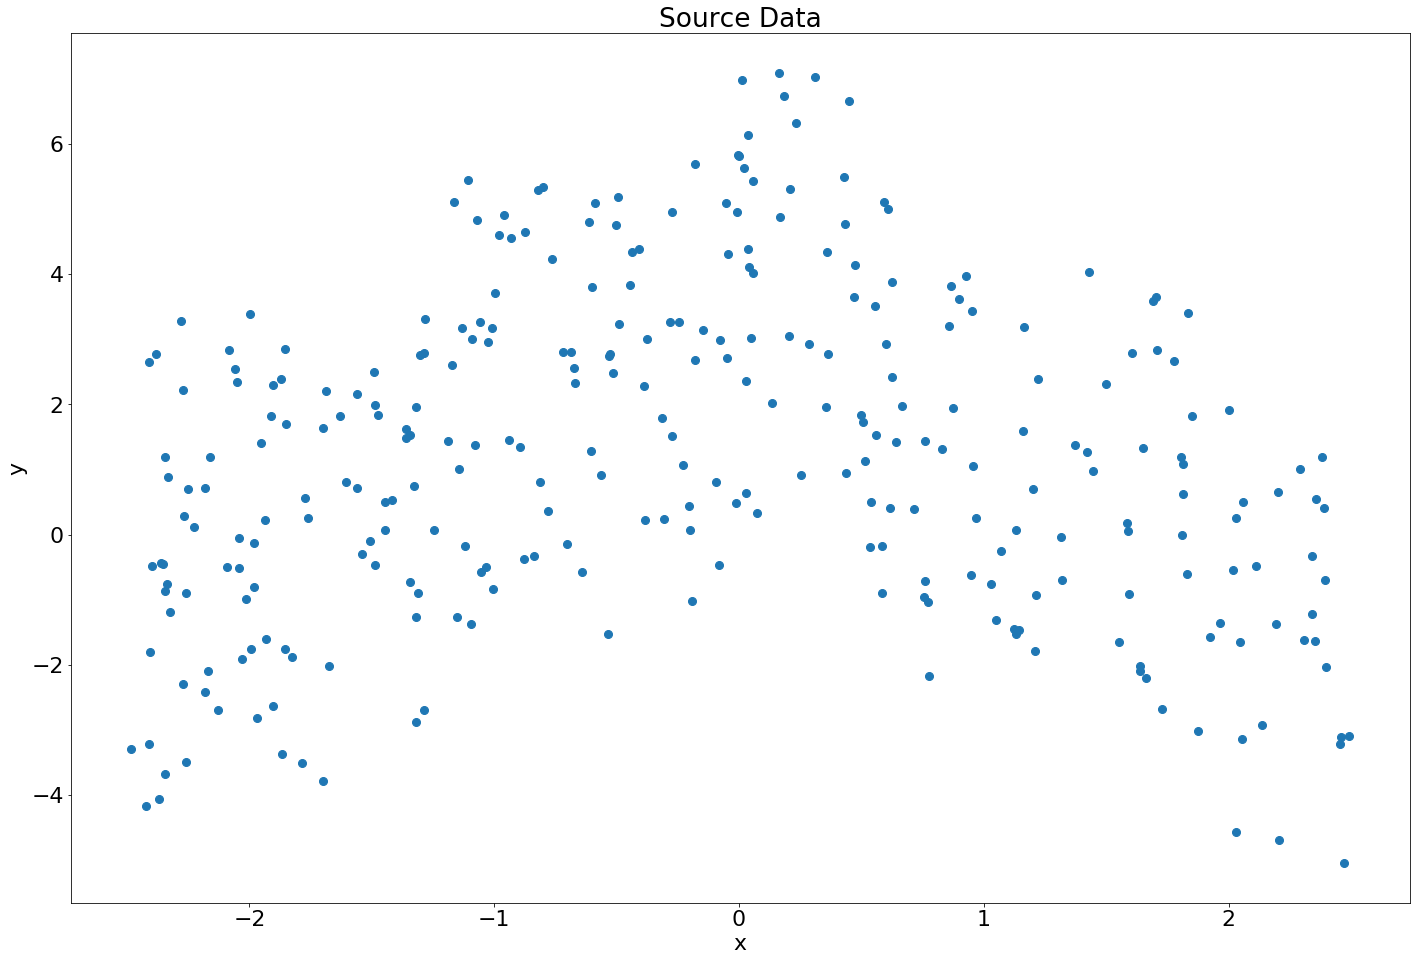

In [3]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylab
import sklearn.linear_model as lm
from sklearn.model_selection import train_test_split

pylab.rcParams['figure.figsize'] = (24.0, 16.0)
plt.rcParams.update({'font.size': 22})

data = pd.read_csv("data.csv")
sample = data.values
x = sample[:, 0]
y = sample[:, 1]

plt.title('Source Data')
plt.xlabel('x')
plt.ylabel('y')
plt.plot(x, y, 'o', markersize=8)

print(len(x))

## Нормализуем данные

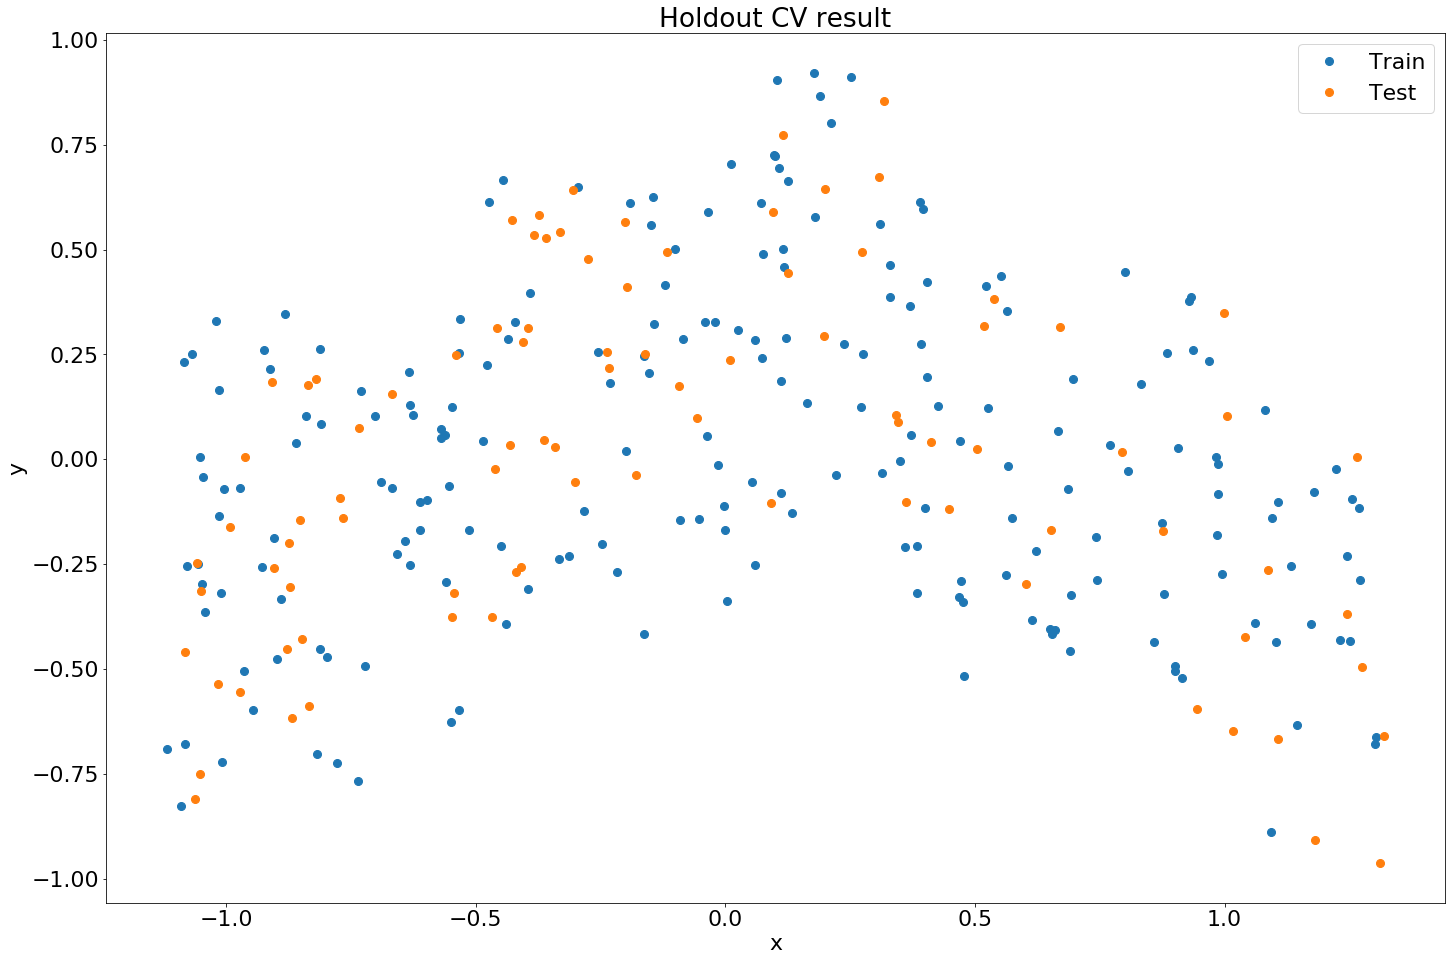

In [4]:
mean_x, mean_y = np.mean(x), np.mean(y)
s_x, s_y = np.var(x, ddof=1), np.var(y, ddof=1)

norm_x = (x - mean_x) / s_x
norm_y = (y - mean_y) / s_y
    
x_train, x_test, y_train, y_test = train_test_split(norm_x, norm_y, test_size=0.3)

fig, ax = plt.subplots(1, 1)
# normalized, splitted = ax[0], ax[1]
splitted = ax

# normalized.set_title('Normalized Data')
# normalized.set_xlabel('x')
# normalized.set_ylabel('y')
# normalized.plot(norm_x, norm_y, 'ro', markersize=8)

splitted.set_title('Holdout CV result')
splitted.set_xlabel('x')
splitted.set_ylabel('y')
splitted.plot(x_train, y_train, 'o', markersize=8, label='Train')
splitted.plot(x_test, y_test, 'o', markersize=8, label='Test')
splitted.legend()

plt.show();

## Строим модели

а) линейной регрессии;

б) LASSO-регрессии при $\lambda \approx 0$;

в) LASSO-регрессии при $\lambda \gg 0$.

In [102]:
LINR_LABEL = 'Linear Regression'
LAMBDA_APPROX_ZERO = 0.005
LAS0_LABEL = 'Lasso ($\\lambda = {}$)'.format(LAMBDA_APPROX_ZERO)
LAMBDA_GG_ZERO = 0.2
LAS1_LABEL = 'Lasso ($\\lambda = {}$)'.format(LAMBDA_GG_ZERO)

labels = [LINR_LABEL, LAS0_LABEL, LAS1_LABEL]

def build_models():
    return [lm.LinearRegression(), lm.Lasso(alpha=LAMBDA_APPROX_ZERO), lm.Lasso(LAMBDA_GG_ZERO)]

def build_regressors(m, x):
    X = np.array([x ** i for i in range(1, m + 1)]).T
    return X

def fit_models(models, m):
    X = build_regressors(m, x_train)
    y = y_train
    for model in models:
        model.fit(X, y)

## 1. Графики зависимости MSE моделей от параметра m (числа регрессоров в регрессионной модели)

Поскольку в данных варианта доступен только один регрессор, построить графики зависимости не представляется возможным. Покажем на графике MSE для всех трёх моделей в случае доступного единственного регрессора:

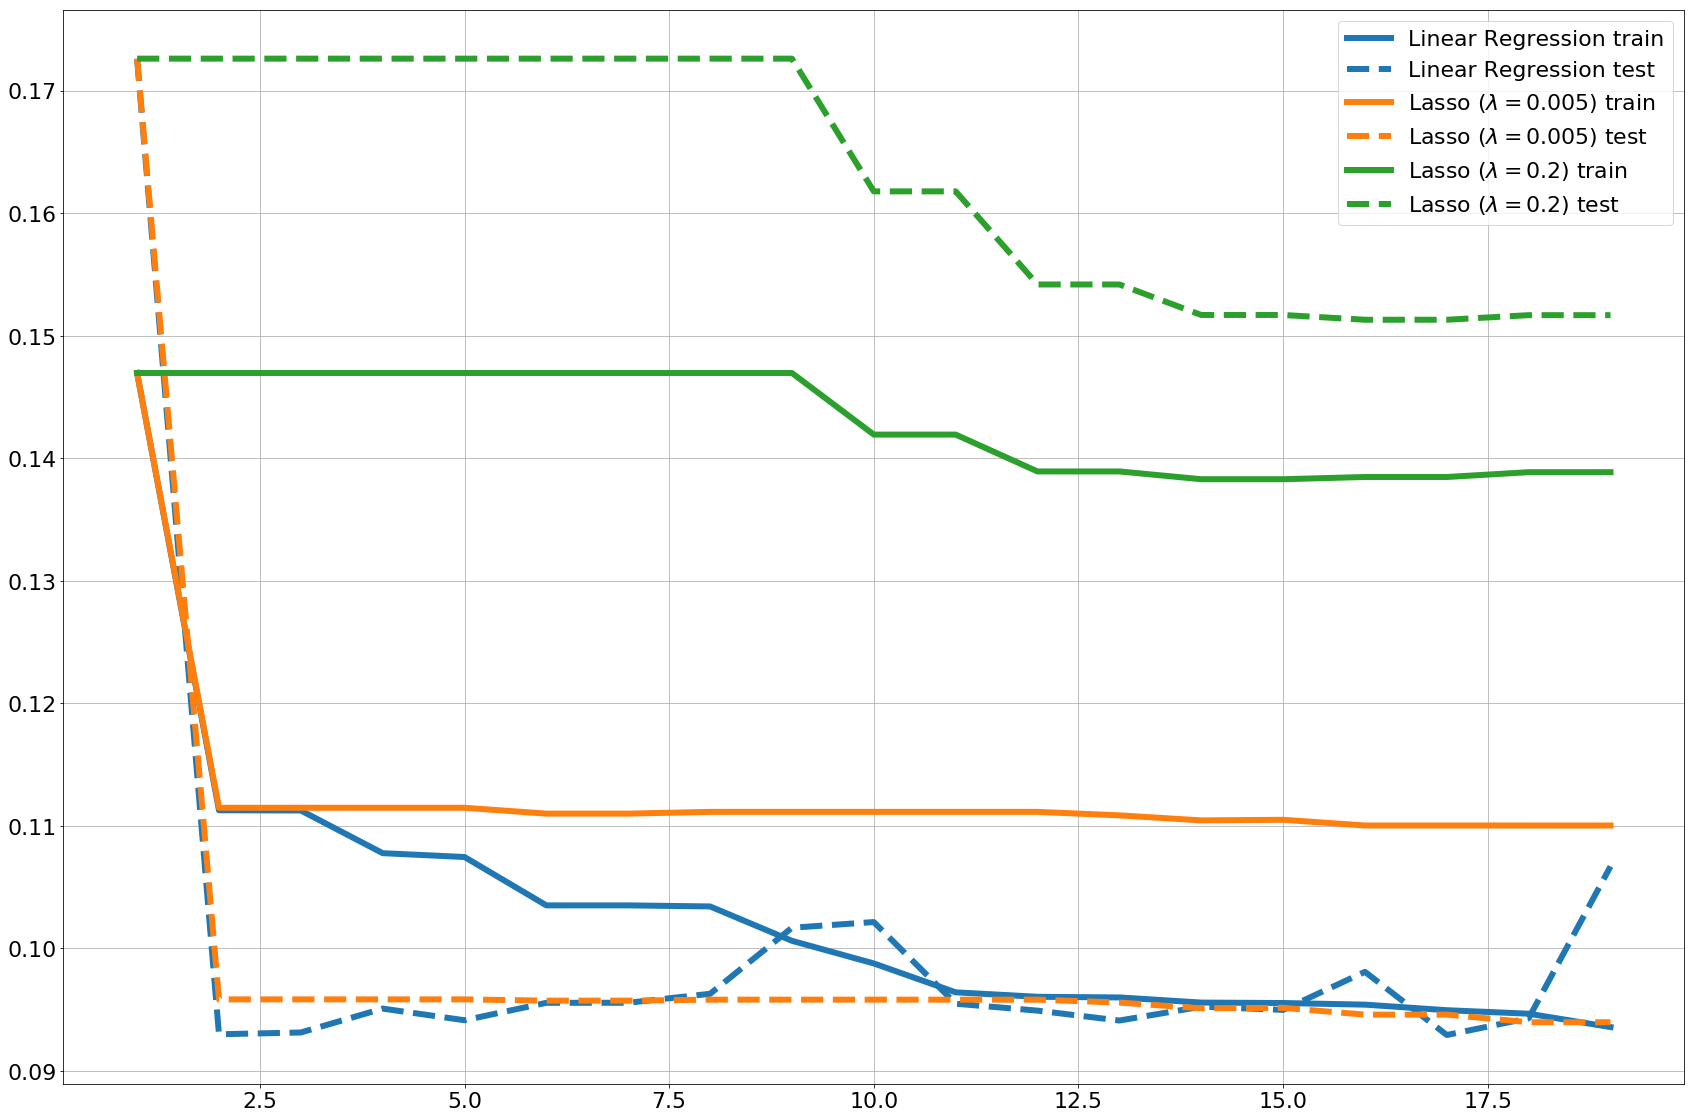

In [97]:
def mse(X, y, model):
    y_model = model.predict(X)
    return np.mean((y - y_model) ** 2)

def calc_mse(model, m):
    X = np.array([x_train ** i for i in range(1, m + 1)]).T
    model.fit(X, y_train)
    return mse(X, y_train, model), mse(np.array([x_test ** i for i in range(1, m + 1)]).T, y_test, model)

ms = list(range(1, 20))
mses_train = [[], [], []]
mses_test =  [[], [], []]
labels = [LINR_LABEL, LAS0_LABEL, LAS1_LABEL]

for m in ms:
    models = build_models()
    for i in range(3):
        mse_train, mse_test = calc_mse(models[i], m)
        mses_train[i].append(mse_train)
        mses_test[i].append(mse_test)

fig, ax = plt.subplots()

for i in range(3):
    label = labels[i]
    line = ax.plot(ms, mses_train[i], label=label + ' train', linewidth=6)
    color = line[0].get_color()
    ax.plot(ms, mses_test[i], '--', label=label + ' test', linewidth=6, color=color)

ax.legend()
ax.grid()

fig.tight_layout()
plt.show();

## 2. Графики выхода регрессионных моделей

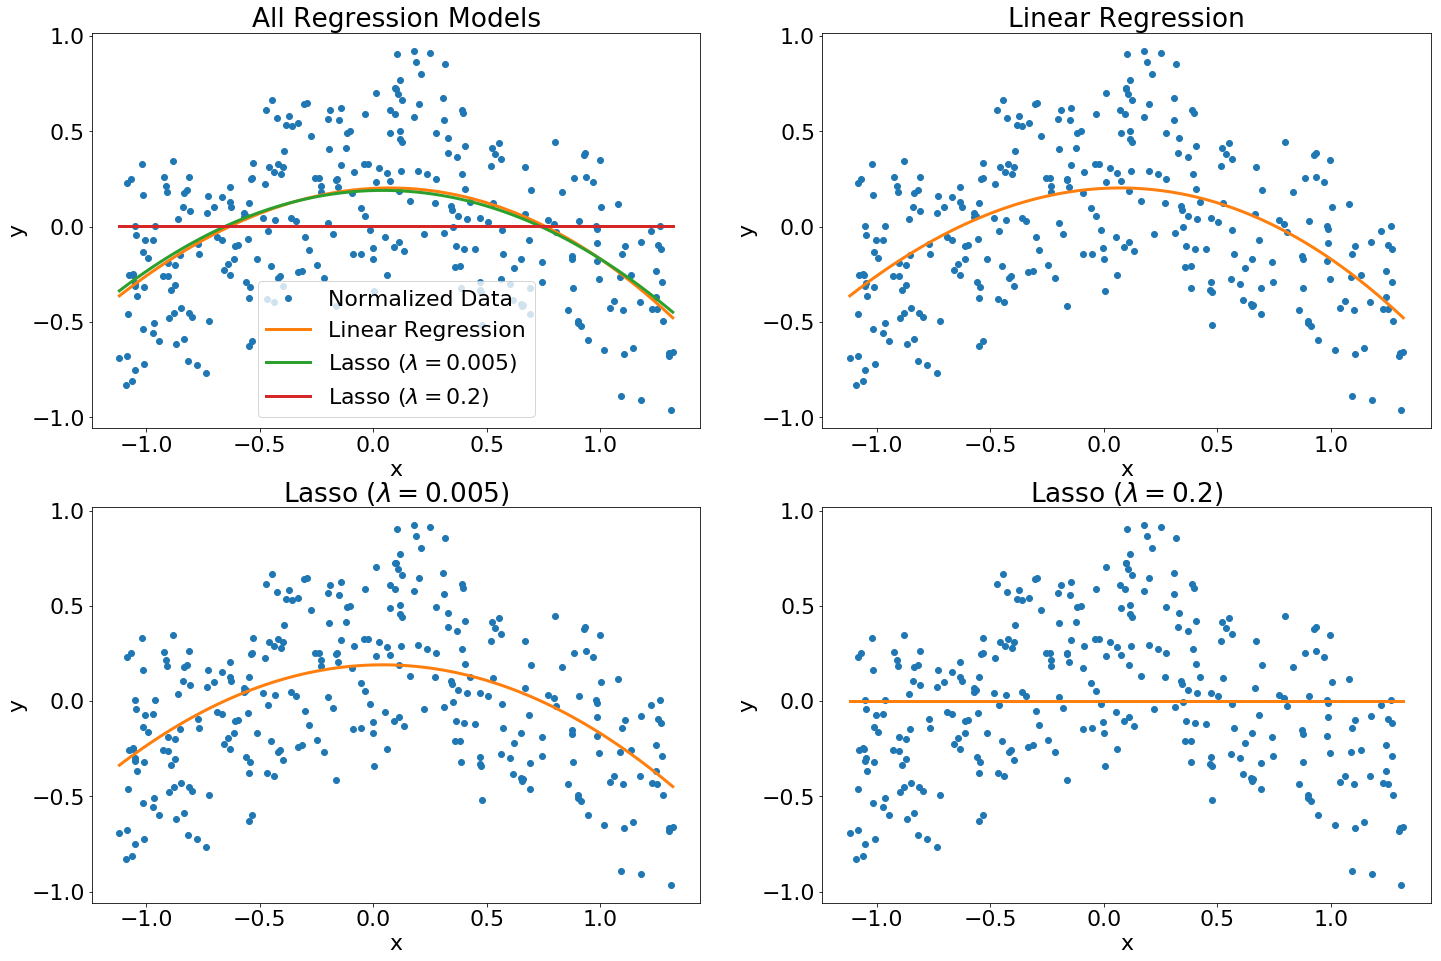

In [98]:
def line(b1, b0):
    line_x = np.array([np.min(norm_x), np.max(norm_x)])
    line_y = line_x * b1 + b0
    return line_x, line_y

fixed_m = 3

models = build_models()
fit_models(models, fixed_m)

def draw(i, canvas):
    domain = np.linspace(min(norm_x), max(norm_x), 100)
    values = models[i].predict(np.array([domain ** i for i in range(1, fixed_m + 1)]).T)
    name = labels[i]
    canvas.plot(domain, values, label=name, lw=3)

fig, ax = plt.subplots(2, 2)
all_in_one = ax[0][0]
singles = [ax[0][1], ax[1][0], ax[1][1]]

all_in_one.set_title('All Regression Models')
all_in_one.set_xlabel('x')
all_in_one.set_ylabel('y')
all_in_one.plot(norm_x, norm_y, 'o', label='Normalized Data', markersize=6)

for i in range(3):
    draw(i, all_in_one)

all_in_one.legend()

for i in range(3):
    canvas = singles[i]
    canvas.set_title(labels[i])
    canvas.set_xlabel('x')
    canvas.set_ylabel('y')
    canvas.plot(norm_x, norm_y, 'o', label='Normalized Data', markersize=6)
    draw(i, canvas)

## 3. Графики зависимости значений коэффициентов регрессионной модели от параметра $\lambda$

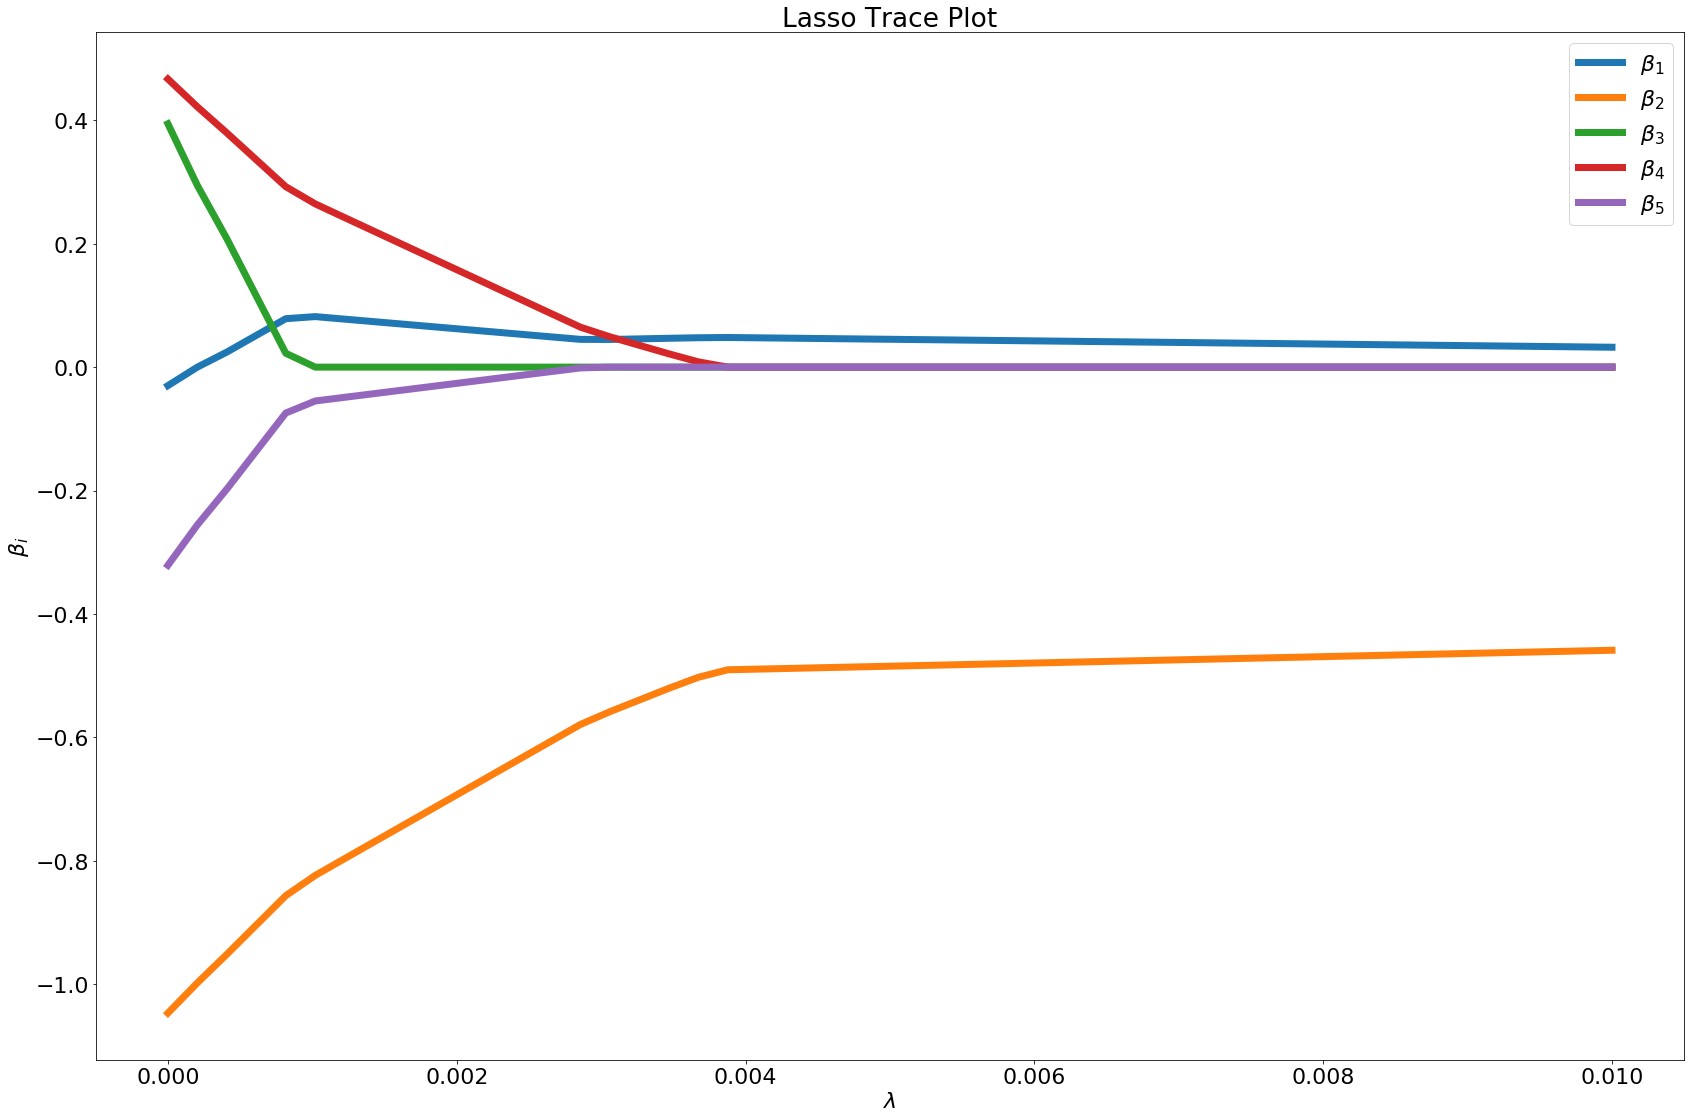

In [126]:
ls = np.linspace(0, 0.01, 50)

fixed_m = 5

def get_coeffs(l):
    if l == 0:
        model = lm.LinearRegression()
    else:
        model = lm.Lasso(alpha=l)
    fit_models([model], fixed_m)
    return model.coef_

coeffs = np.array([get_coeffs(l) for l in ls]).T

# b0s = [c[0] for c in coeffs]
# b1s = [c[1] for c in coeffs]

fig, ax = plt.subplots()

for i in range(len(coeffs)):
    ax.plot(ls, coeffs[i], label='$\\beta_{}$'.format(i + 1), linewidth=7)
#     ax.plot(ls, b0s, label='$\\beta_0$')

ax.set_title('Lasso Trace Plot')
ax.set_xlabel('$\\lambda$')
ax.set_ylabel('$\\beta_i$')

ax.legend()

fig.tight_layout()
plt.show();

## 4. Дисперсия отклика модели

In [104]:
N = 50

def variance(model, x_train, y_train, x_test, y_test):
#     model.fit(np.reshape(x_train, (len(x_train), 1)), y_train)
    y_model_train = model.predict(build_regressors(fixed_m, x_train))
    y_model_test = model.predict(build_regressors(fixed_m, x_test))
    var_train, var_test = np.var(y_model_train), np.var(y_model_test)
    return var_train, var_test

vars_linr = []
vars_las0 = []
vars_las1 = []

for i in range(N):
    x_train, x_test, y_train, y_test = train_test_split(norm_x, norm_y, test_size=0.3)
    
    models = build_models()
    fit_models(models, m=fixed_m)
    
    vars_linr.append(variance(models[0], x_train, y_train, x_test, y_test))
    vars_las0.append(variance(models[1], x_train, y_train, x_test, y_test))
    vars_las1.append(variance(models[2], x_train, y_train, x_test, y_test))

arrs = [vars_linr, vars_las0, vars_las1]
labels = [LINR_LABEL, LAS0_LABEL, LAS1_LABEL]

def draw_hist(i, bins='auto'):
    fig, ax = plt.subplots()

    arr = arrs[i]
    label = labels[i]
    var_train = [v[0] for v in arr]
    var_test  = [v[1] for v in arr]

    ax.hist(var_train, bins, label='Train', alpha=0.6)
    ax.hist(var_test, bins, label='Test', alpha=0.6)

    ax.set_title('$D[\\tilde{y}]$ for ' + label)
    ax.legend()

    plt.show();

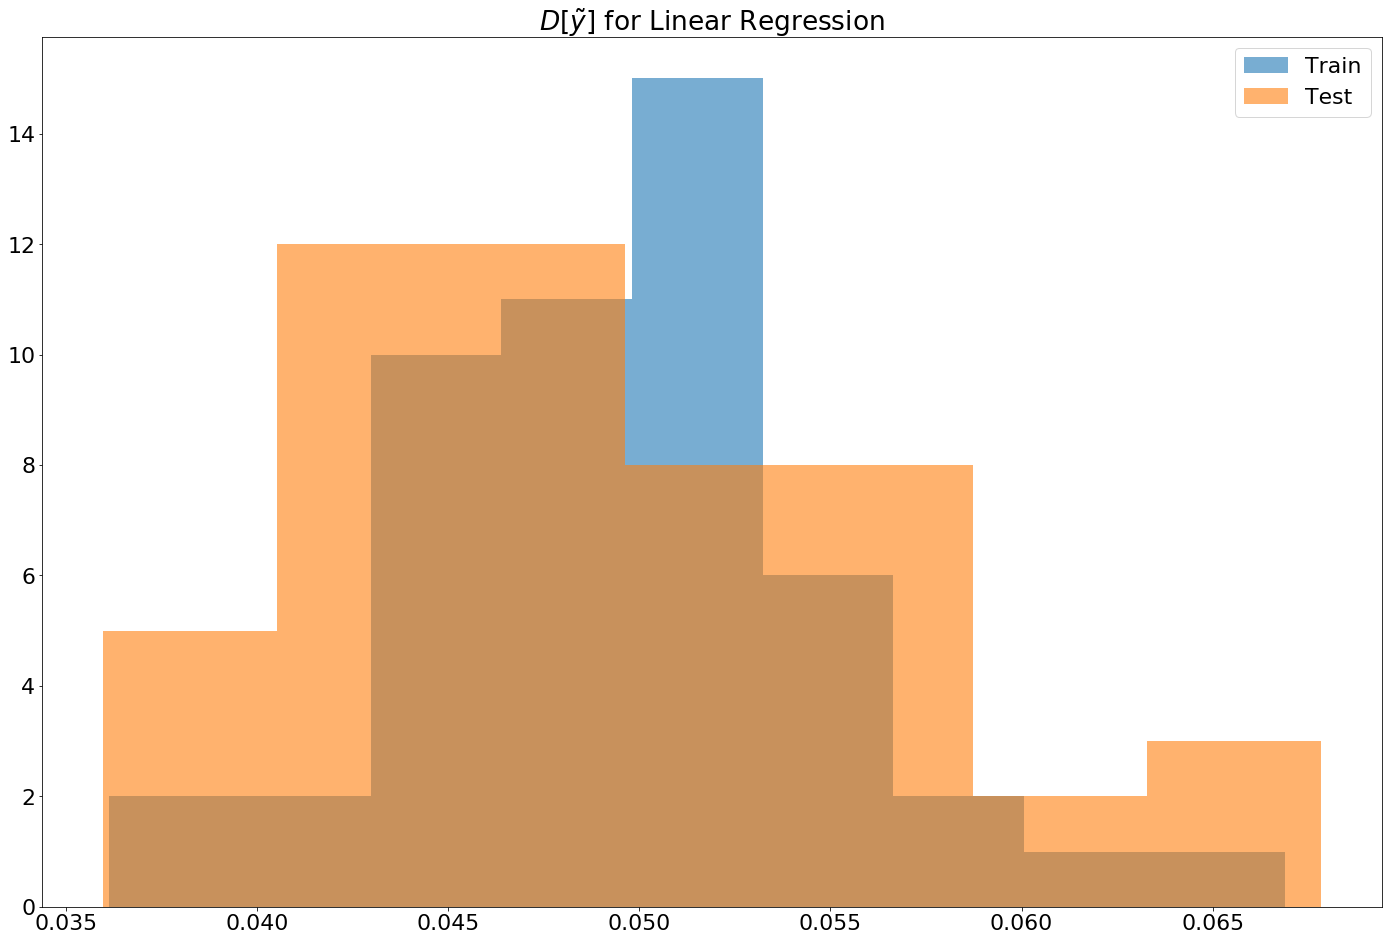

In [105]:
draw_hist(0)

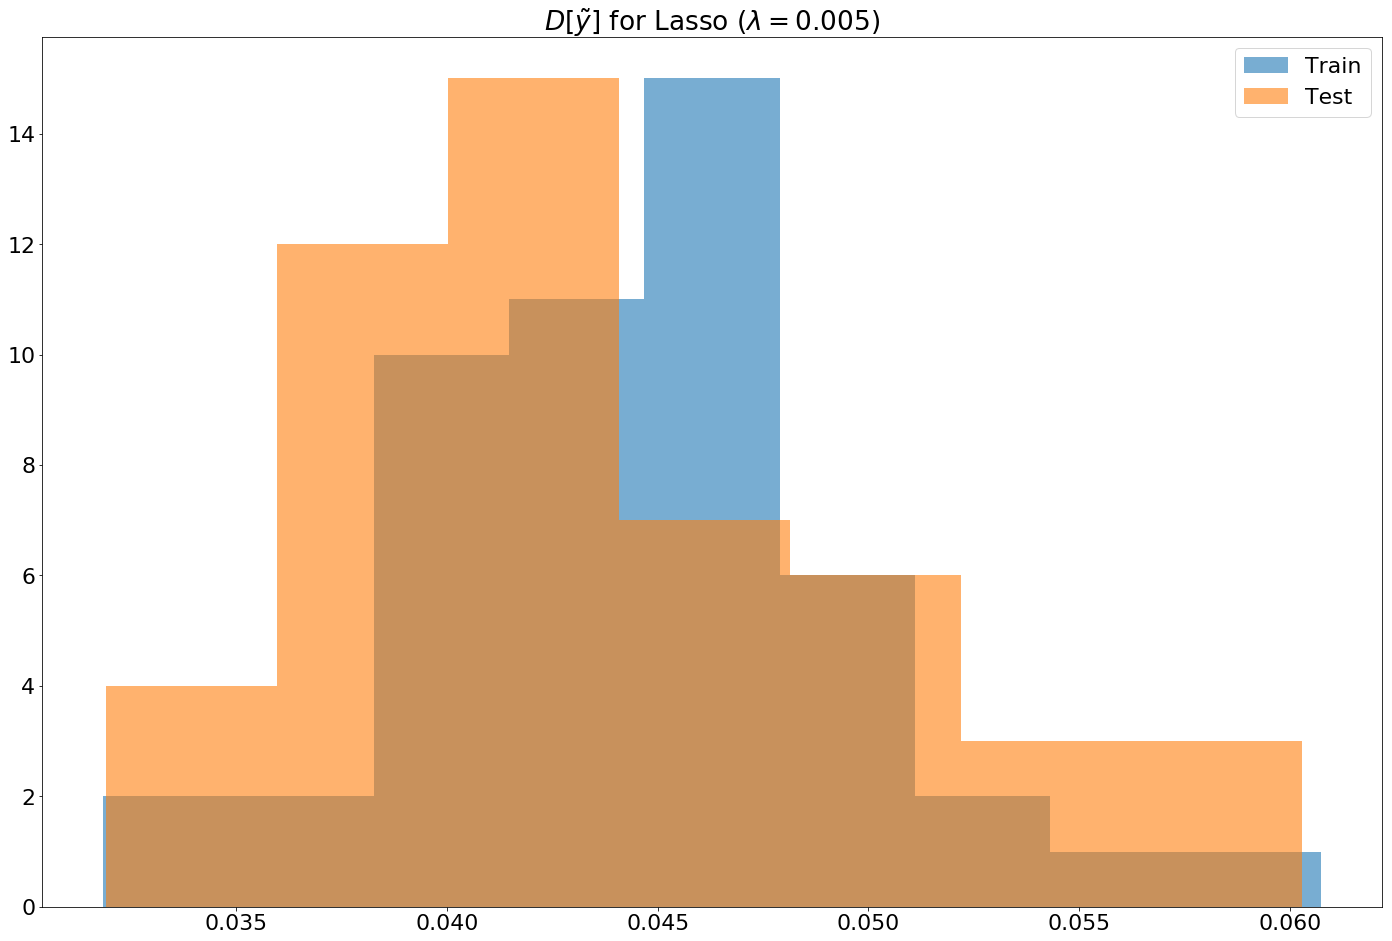

In [107]:
draw_hist(1)

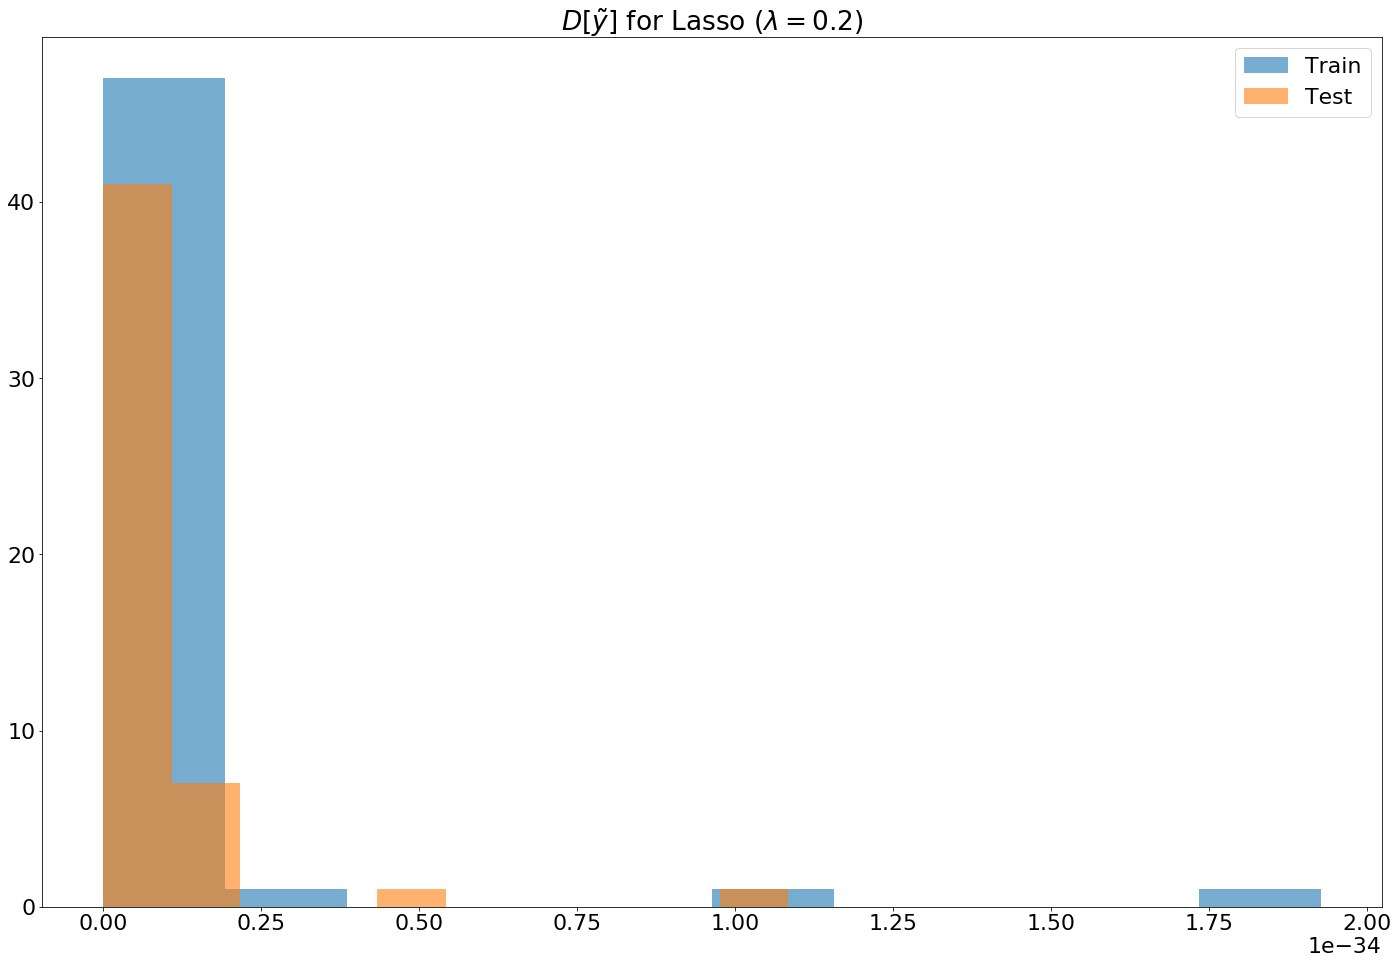

In [111]:
draw_hist(2, 10)

## 5. Исследование регрессионных остатков

In [118]:
def get_es(model, x, y):
    y_model = model.predict(build_regressors(fixed_m, x))
    return y - y_model

def draw_es_for_model(model, label):
    x_ind_sorted = np.argsort(norm_x)
    y_ind_sorted = np.argsort(norm_y)

    es = get_es(model, norm_x, norm_y)

    print('M[e] = {} for {}'.format(np.mean(es), label))

    fig, ax = plt.subplots(1, 2)

    ax[0].set_title('Зависимость e(x) для {}'.format(label))
    ax[0].set_xlabel('x')
    ax[0].set_ylabel('e')
    ax[0].plot(norm_x[x_ind_sorted], es[x_ind_sorted])

    ax[1].set_title('Зависимость e(y) для {}'.format(label))
    ax[1].set_xlabel('y')
    ax[1].set_ylabel('e')
    ax[1].plot(norm_y[y_ind_sorted], es[y_ind_sorted])

    plt.show();
    
models = build_models()
fit_models(models, m=fixed_m)

M[e] = -0.004427445208370521 for Linear Regression


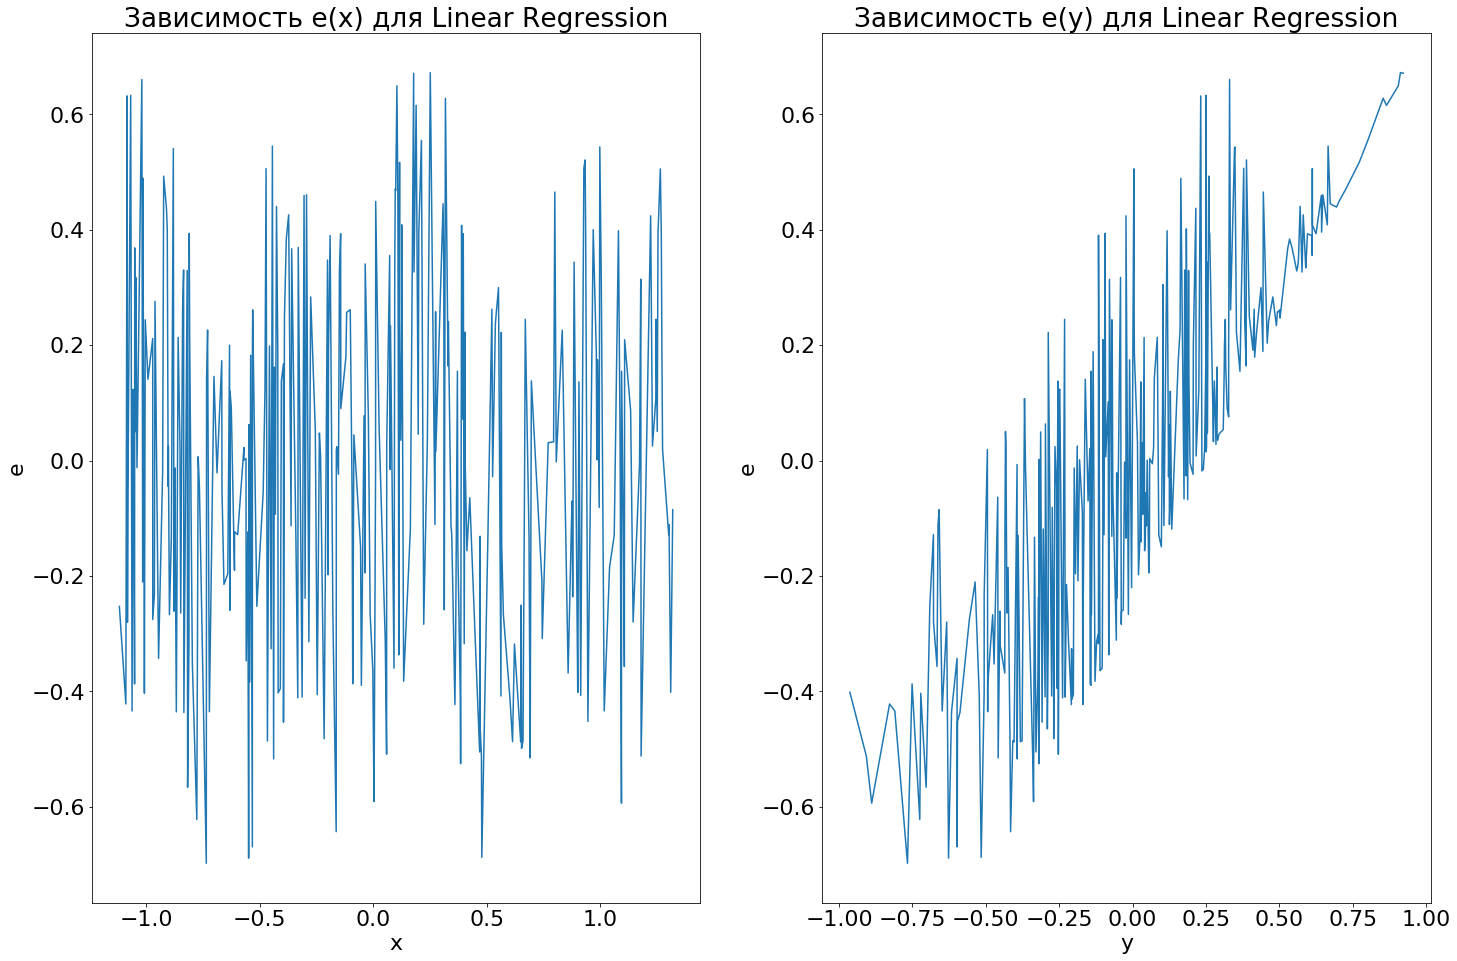

In [119]:
draw_es_for_model(models[0], LINR_LABEL)

M[e] = -0.004505759492630022 for Lasso ($\lambda = 0.005$)


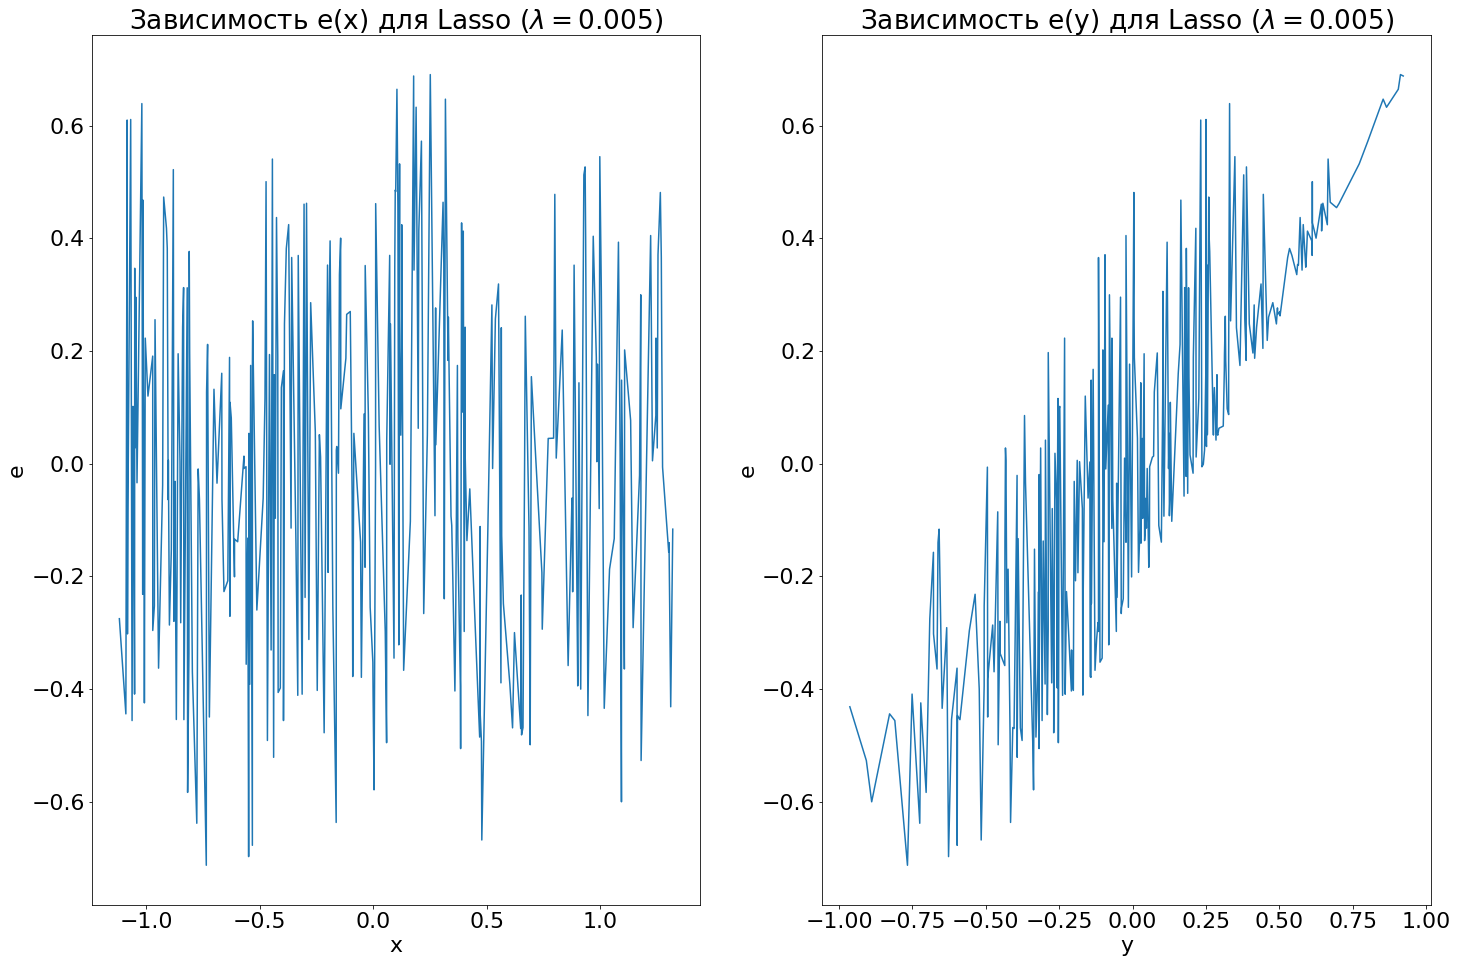

In [120]:
draw_es_for_model(models[1], LAS0_LABEL)

M[e] = -0.01133446864220145 for Lasso ($\lambda = 0.2$)


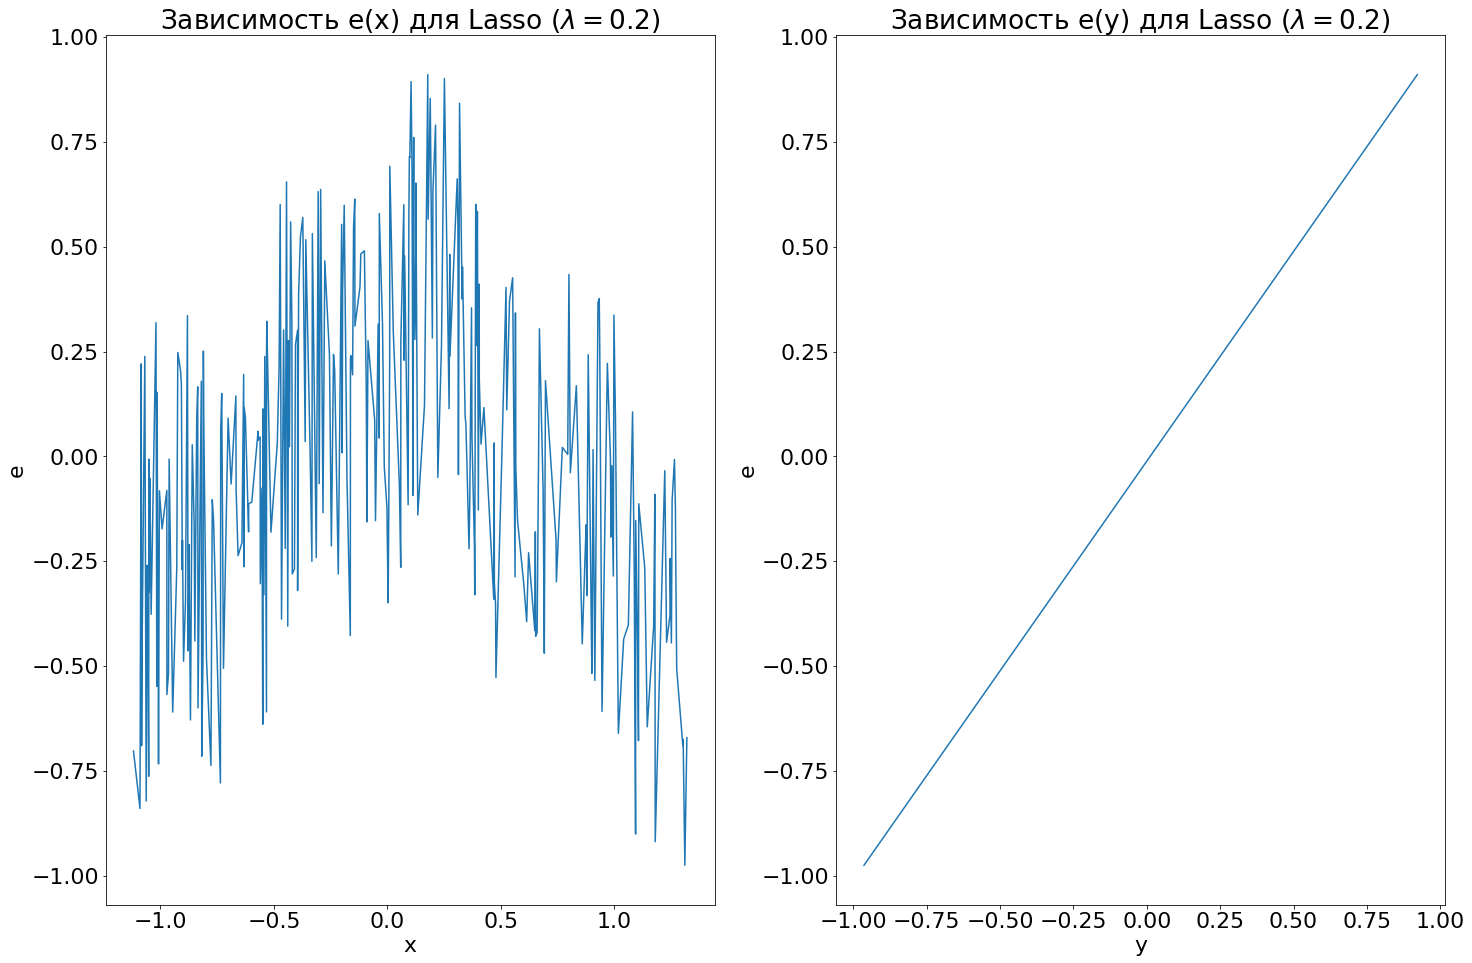

In [121]:
draw_es_for_model(models[2], LAS1_LABEL)